In [1]:
import torch
from torchvision import datasets, transforms
import os
import load_model
import eval
import numpy as np
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from PIL import Image
import torchvision.transforms as T
import numpy as np
import torch.nn.utils.prune as prune


device = torch.device(f"cuda:0") if torch.cuda.is_available() else 'cpu'
print(device)

cuda:0


In [22]:
def convert_GAL_layers(GAL_model, i):
    features = GAL_model.feature
    cnt = 0
    while cnt <= i:
        if isinstance(features[i], load_model.Mask):
            i += 1
        cnt += 1
    return i

In [13]:
def get_sparsity_GAL(GAL_model):
    pruned = 0
    num = 0

    for i, (name, param) in enumerate(GAL_model.named_parameters()):
        if 'feature' in name and isinstance(GAL_model.feature[int(name.split('.')[1])], load_model.Mask):
            weight_copy = param.clone()
            param_array = np.array(weight_copy.detach().cpu())
            pruned += sum(w == 0 for w in param_array)
            num += len(param_array)

    print("Pruned {} / {} = {}".format(pruned, num, pruned/num))

def get_sparsity_lottery(lottery_jackpot_model):
    pruned = 0
    num = 0
    for layer in lottery_jackpot_model.feature:
        if isinstance(layer, load_model.PretrainConv):
            pruned += torch.sum(layer.b_mask == 0)
            num += torch.numel(layer.b_mask)
    print("Pruned {} / {} = {}".format(pruned, num, pruned/num))

def get_sparsity_prune_scratch(model):
    pruned = 0
    num = 0
    cnt = 0
    cfg = [64, 64, 128, 128, 256, 256, 256, 256, 512, 512, 512, 512, 512, 512, 512, 512]
    for layer in model.feature:
        if isinstance(layer, torch.nn.Conv2d):
            pruned += cfg[cnt] - layer.weight.shape[0]
            num += cfg[cnt]
            cnt += 1
    print("Pruned {} / {} = {}".format(pruned, num, pruned/num))

def get_sparsity_vanilla(model):
    pruned = 0
    num = 0
    for layer in model.feature:
        if isinstance(layer, torch.nn.Conv2d) or isinstance(layer, torch.nn.Linear):
            pruned += torch.sum(layer.weight == 0)
            num += torch.numel(layer.weight)
    print("Pruned {} / {} = {}".format(pruned, num, pruned/num))

In [2]:
def get10(batch_size, data_root='/tmp/public_dataset/pytorch', train=True, val=True, **kwargs):
    data_root = os.path.expanduser(os.path.join(data_root, 'cifar10-data'))
    num_workers = kwargs.setdefault('num_workers', 1)
    kwargs.pop('input_size', None)
    print("Building CIFAR-10 data loader with {} workers".format(num_workers))
    ds = []
    if train:
        train_loader = torch.utils.data.DataLoader(
            datasets.CIFAR10(
                root=data_root, train=True, download=True,
                transform=transforms.Compose([
                    transforms.Pad(4),
                    transforms.RandomCrop(32),
                    transforms.RandomHorizontalFlip(),
                    transforms.ToTensor(),
                    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
                ])),
            batch_size=batch_size, shuffle=True, **kwargs)
        ds.append(train_loader)
    if val:
        test_loader = torch.utils.data.DataLoader(
            datasets.CIFAR10(
                root=data_root, train=False, download=True,
                transform=transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
                ])),
            batch_size=batch_size, shuffle=False, **kwargs)
        ds.append(test_loader)
    ds = ds[0] if len(ds) == 1 else ds
    return ds

train_loader, test_loader = get10(batch_size=200, num_workers=1)

Building CIFAR-10 data loader with 1 workers
Files already downloaded and verified
Files already downloaded and verified


In [5]:
pretrain_model = load_model.get_GraSP_VGG('./saved_models/pretrain_best_lottery.pt')
pretrain_model.eval()
eval.validate(pretrain_model, test_loader)

Test Loss 0.2991	Accurary 93.79%		Time 5.97s



93.79000091552734

In [6]:
GAL_model = load_model.get_GAL_VGG('./saved_models/gal_best_model-state.pt')
GAL_model.eval()
eval.validate(GAL_model, test_loader)
get_sparsity_GAL(GAL_model)
# Structured Pruning: 0.48 sparsity

Test Loss 0.4720	Accurary 91.89%		Time 5.60s

Pruned 2609 / 5504 = 0.47401889534883723


In [7]:
GraSP_model = load_model.get_GraSP_VGG('./saved_models/grasp_best_model_state.pt')
GraSP_model.eval()
eval.validate(GraSP_model, test_loader)
# 0.9800 sparsity

Test Loss 0.2590	Accurary 92.31%		Time 5.52s



92.30999755859375

In [8]:
lottery_jackpot_model = load_model.get_lottery_VGG('./saved_models/lottery-jackpots-best.pt')
lottery_jackpot_model.eval()
eval.validate(lottery_jackpot_model, test_loader)
get_sparsity_lottery(lottery_jackpot_model)

Test Loss 0.3980	Accurary 90.60%		Time 5.49s

Pruned 18016993 / 20018880 = 0.9000000357627869


In [9]:
prune_scratch_model = load_model.get_prune_scratch_VGG('./saved_models/prune-scratch-best.pth')
prune_scratch_model.eval()
eval.validate(prune_scratch_model, test_loader)
get_sparsity_prune_scratch(prune_scratch_model)

Test Loss 0.3781	Accurary 92.38%		Time 5.43s

Pruned 3005 / 5504 = 0.5459665697674418


In [37]:
vanilla_one_shot_model = load_model.get_GraSP_VGG('./saved_models/vanilla_pruning_one_shot_best.pt')
vanilla_one_shot_model.eval()
eval.validate(vanilla_one_shot_model, test_loader)
get_sparsity_vanilla(vanilla_one_shot_model)

Test Loss 0.3395	Accurary 91.63%		Time 8.49s

Pruned 16015104 / 20018880 = 0.800000011920929


In [38]:
vanilla_iterative_model = load_model.get_GraSP_VGG('./saved_models/vanilla_pruning_iterative_best.pt')
vanilla_iterative_model.eval()
eval.validate(vanilla_iterative_model, test_loader)
get_sparsity_vanilla(vanilla_iterative_model)

Test Loss 1.7032	Accurary 36.70%		Time 10.78s

Pruned 19590763 / 20018880 = 0.9786143898963928


In [23]:
print('Layer:', pretrain_model.feature[27])
comp_methods = ['cosine', 'l2', 'iou']
comp_results = eval.grad_cam_batch(pretrain_model, GAL_model, test_loader, comp_methods=comp_methods, target_layers_x=[pretrain_model.feature[27]], target_layers_y=[GAL_model.feature[convert_GAL_layers(GAL_model, 27)]])
for i in range(len(comp_methods)):
    print(f"{comp_methods[i]}: {comp_results[i]}")

print('Layer:', pretrain_model.feature[49])
comp_results = eval.grad_cam_batch(pretrain_model, GAL_model, test_loader, comp_methods=comp_methods, target_layers_x=[pretrain_model.feature[49]], target_layers_y=[GAL_model.feature[convert_GAL_layers(GAL_model, 49)]])
for i in range(len(comp_methods)):
    print(f"{comp_methods[i]}: {comp_results[i]}")

Layer: Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
cosine: 0.5867461464355933
l2: 113.46693324871063
iou: 0.2493694517539057
Layer: Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
cosine: 0.7314961334007792
l2: 319.62919090776444
iou: 0.13278389662017484


In [24]:
print('Layer:', pretrain_model.feature[27])
comp_methods = ['cosine', 'l2', 'iou']
comp_results = eval.grad_cam_batch(pretrain_model, GraSP_model, test_loader, comp_methods=comp_methods, target_layers_x=[pretrain_model.feature[27]], target_layers_y=[GraSP_model.feature[27]])
for i in range(len(comp_methods)):
    print(f"{comp_methods[i]}: {comp_results[i]}")

print('Layer:', pretrain_model.feature[49])
comp_results = eval.grad_cam_batch(pretrain_model, GraSP_model, test_loader, comp_methods=comp_methods, target_layers_x=[pretrain_model.feature[49]], target_layers_y=[GraSP_model.feature[49]])
for i in range(len(comp_methods)):
    print(f"{comp_methods[i]}: {comp_results[i]}")

Layer: Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
cosine: 0.7374778390676715
l2: 96.8019768294692
iou: 0.3673279530348567
Layer: Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
cosine: 0.7569860420271755
l2: 185.79371955824644
iou: 0.5563291380787335


In [25]:
print('Layer:', pretrain_model.feature[27])
comp_methods = ['cosine', 'l2', 'iou']
comp_results = eval.grad_cam_batch(pretrain_model, lottery_jackpot_model, test_loader, comp_methods=comp_methods, target_layers_x=[pretrain_model.feature[27]], target_layers_y=[lottery_jackpot_model.feature[27]])
for i in range(len(comp_methods)):
    print(f"{comp_methods[i]}: {comp_results[i]}")

print('Layer:', pretrain_model.feature[49])
comp_results = eval.grad_cam_batch(pretrain_model, lottery_jackpot_model, test_loader, comp_methods=comp_methods, target_layers_x=[pretrain_model.feature[49]], target_layers_y=[lottery_jackpot_model.feature[49]])
for i in range(len(comp_methods)):
    print(f"{comp_methods[i]}: {comp_results[i]}")

Layer: Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
cosine: 0.5538904573363236
l2: 156.09367731590496
iou: 0.1867671914770312
Layer: Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
cosine: 0.7383427382711321
l2: 201.65296653740256
iou: 0.5320506244566685


In [26]:
print('Layer:', pretrain_model.feature[27])
comp_methods = ['cosine', 'l2', 'iou']
comp_results = eval.grad_cam_batch(pretrain_model, prune_scratch_model, test_loader, comp_methods=comp_methods, target_layers_x=[pretrain_model.feature[27]], target_layers_y=[prune_scratch_model.feature[27]])
for i in range(len(comp_methods)):
    print(f"{comp_methods[i]}: {comp_results[i]}")

print('Layer:', pretrain_model.feature[49])
comp_results = eval.grad_cam_batch(pretrain_model, prune_scratch_model, test_loader, comp_methods=comp_methods, target_layers_x=[pretrain_model.feature[49]], target_layers_y=[prune_scratch_model.feature[49]])
for i in range(len(comp_methods)):
    print(f"{comp_methods[i]}: {comp_results[i]}")

Layer: Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
cosine: 0.6525998556832187
l2: 94.3565732483685
iou: 0.2131741361831499
Layer: Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
cosine: 0.717332073931396
l2: 217.63826655632892
iou: 0.5309242440224499


In [39]:
print('Layer:', pretrain_model.feature[27])
comp_methods = ['cosine', 'l2', 'iou']
comp_results = eval.grad_cam_batch(pretrain_model, vanilla_one_shot_model, test_loader, comp_methods=comp_methods, target_layers_x=[pretrain_model.feature[27]], target_layers_y=[vanilla_one_shot_model.feature[27]])
for i in range(len(comp_methods)):
    print(f"{comp_methods[i]}: {comp_results[i]}")

print('Layer:', pretrain_model.feature[49])
comp_results = eval.grad_cam_batch(pretrain_model, vanilla_one_shot_model, test_loader, comp_methods=comp_methods, target_layers_x=[pretrain_model.feature[49]], target_layers_y=[vanilla_one_shot_model.feature[49]])
for i in range(len(comp_methods)):
    print(f"{comp_methods[i]}: {comp_results[i]}")

Layer: Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
cosine: 0.9585252067331225
l2: 12.53978801158631
iou: 0.7351389884318381
Layer: Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
cosine: 0.867327181661129
l2: 106.02107745045535
iou: 0.7243978025203325


In [40]:
print('Layer:', pretrain_model.feature[27])
comp_methods = ['cosine', 'l2', 'iou']
comp_results = eval.grad_cam_batch(pretrain_model, vanilla_iterative_model, test_loader, comp_methods=comp_methods, target_layers_x=[pretrain_model.feature[27]], target_layers_y=[vanilla_iterative_model.feature[27]])
for i in range(len(comp_methods)):
    print(f"{comp_methods[i]}: {comp_results[i]}")

print('Layer:', pretrain_model.feature[49])
comp_results = eval.grad_cam_batch(pretrain_model, vanilla_iterative_model, test_loader, comp_methods=comp_methods, target_layers_x=[pretrain_model.feature[49]], target_layers_y=[vanilla_iterative_model.feature[49]])
for i in range(len(comp_methods)):
    print(f"{comp_methods[i]}: {comp_results[i]}")

Layer: Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
cosine: 0.6865991828590282
l2: 151.5021985485196
iou: 0.27158243158955525
Layer: Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
cosine: 0.7644594909563661
l2: 195.75469706335315
iou: 0.5569429165509308


In [11]:
inputs = None
for batch, labels in test_loader:
    inputs = batch
    outputs = labels
    img = batch[0,:,:,:]
    break

In [12]:
def grad_cam_visualization(model, input_tensor=None, target_layers=None):
    if target_layers == None:
        target_layers = [model.features[-14]]
    if input_tensor == None:
        input_tensor = batch # Create an input tensor image for your model..
    # Note: input_tensor can be a batch tensor with several images!

    # Construct the CAM object once, and then re-use it on many images:
    cam = GradCAM(model=model, target_layers=target_layers)

    # You can also use it within a with statement, to make sure it is freed,
    # In case you need to re-create it inside an outer loop:
    # with GradCAM(model=model, target_layers=target_layers) as cam:
    #   ...

    # We have to specify the target we want to generate
    # the Class Activation Maps for.
    # If targets is None, the highest scoring category
    # will be used for every image in the batch.
    # Here we use ClassifierOutputTarget, but you can define your own custom targets
    # That are, for example, combinations of categories, or specific outputs in a non standard model.

    targets = [ClassifierOutputTarget(outputs[index])]

    # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

    # In this example grayscale_cam has only one image in the batch:
    grayscale_cam = grayscale_cam[0, :]
    # print(grayscale_cam.min(), grayscale_cam.max(), grayscale_cam.dtype)
    # print(rgb_img.min(), rgb_img.max(), rgb_img.dtype)
    visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
    return visualization


Pretrained Model, Lottery Jackpot Model, GAL Model, GraSP Model, Prune From Scratch Model
layer: 0 Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


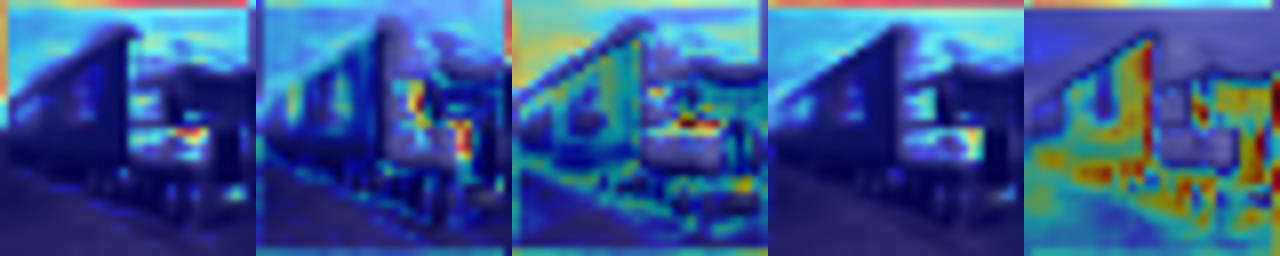

layer: 3 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


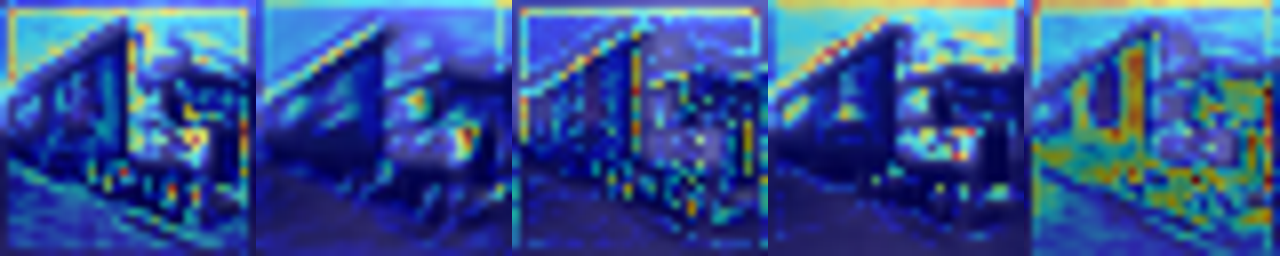

layer: 7 Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


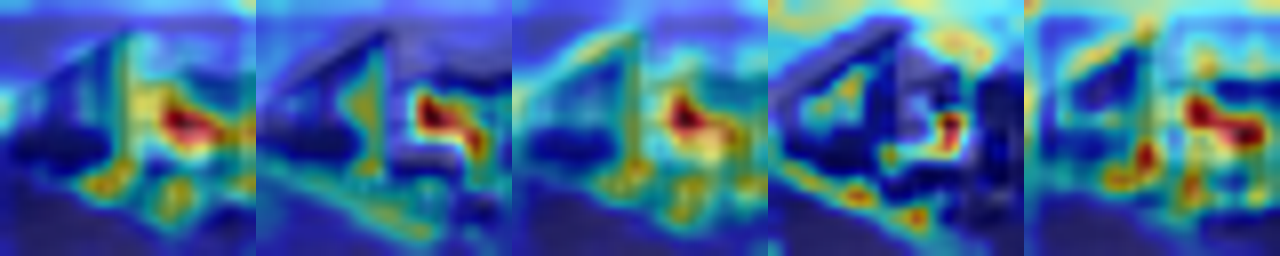

layer: 10 Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


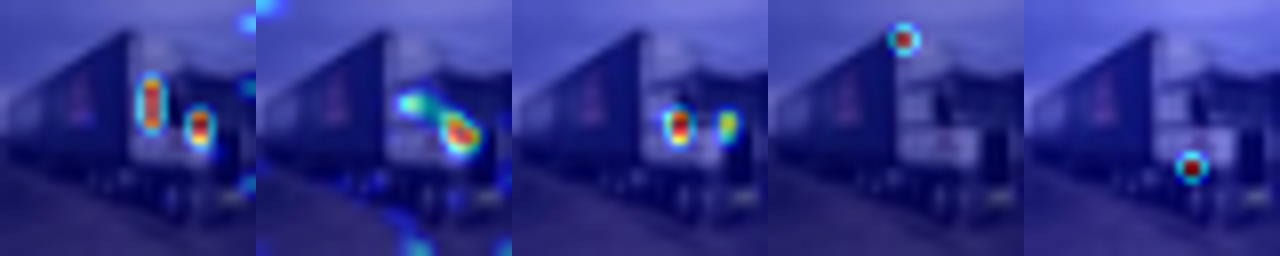

layer: 14 Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


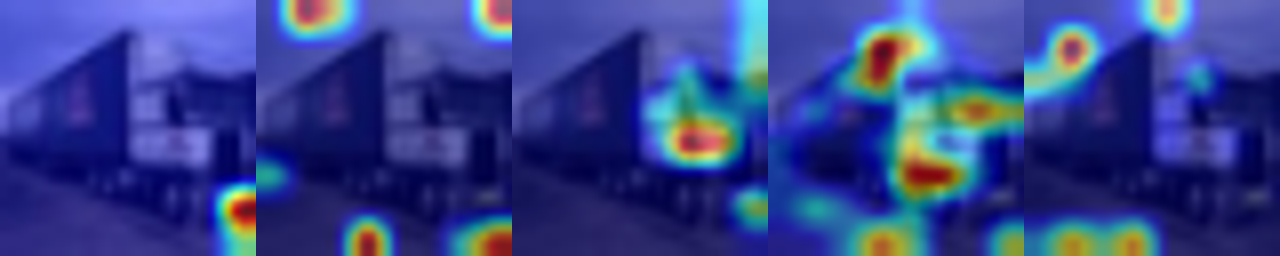

layer: 17 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


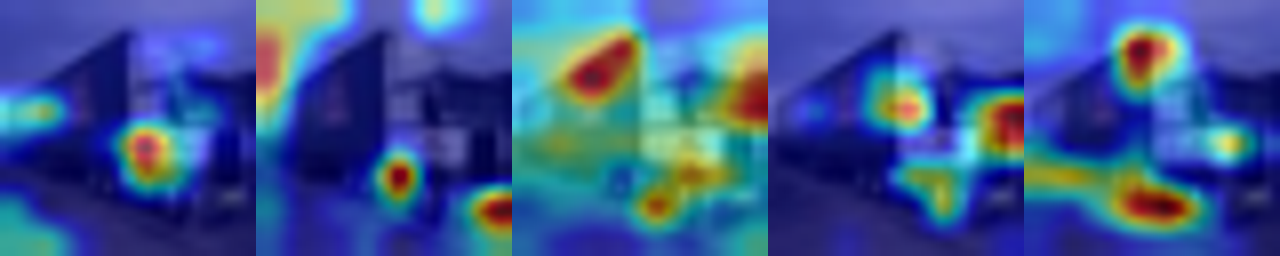

layer: 20 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


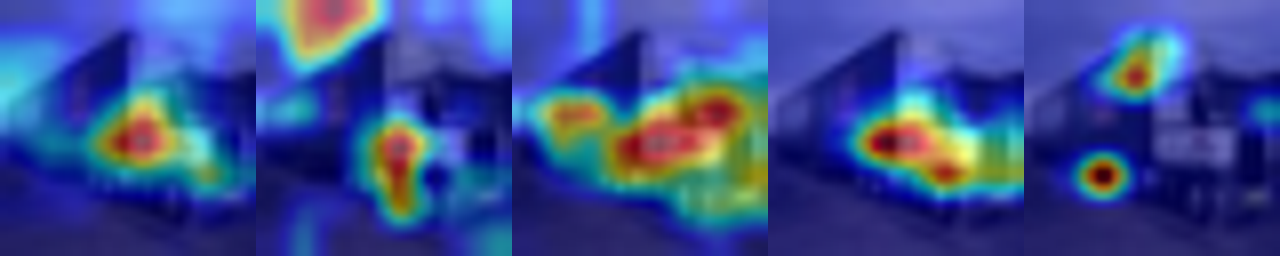

layer: 23 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


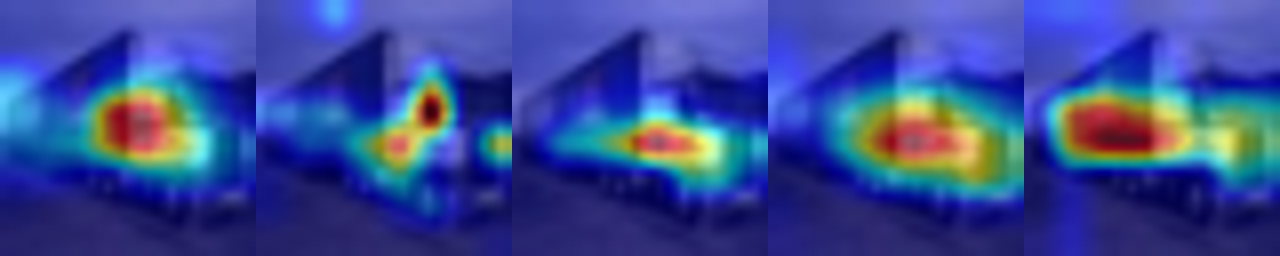

layer: 27 Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


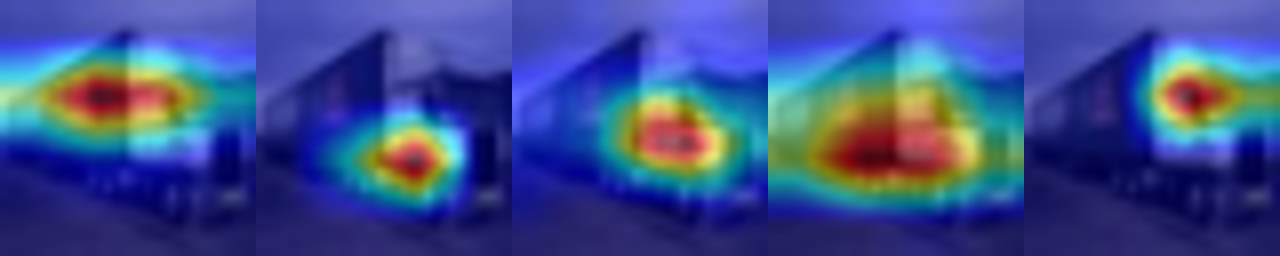

layer: 30 Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


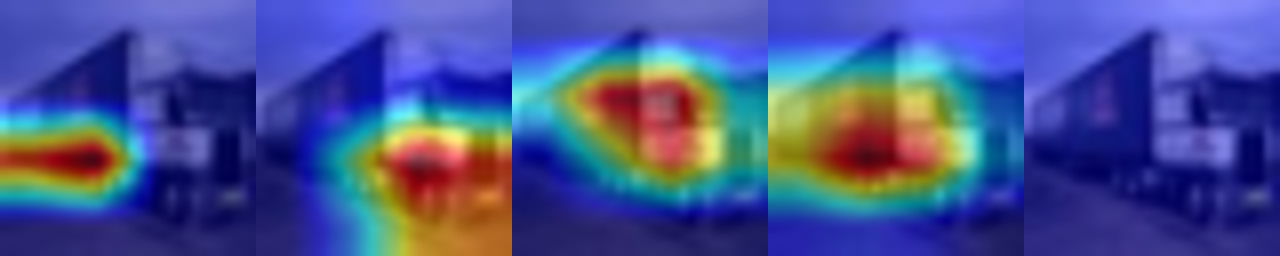

layer: 33 Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


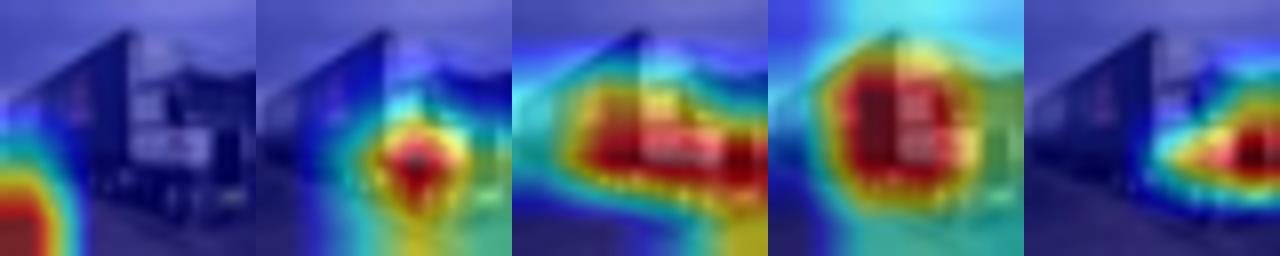

layer: 36 Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


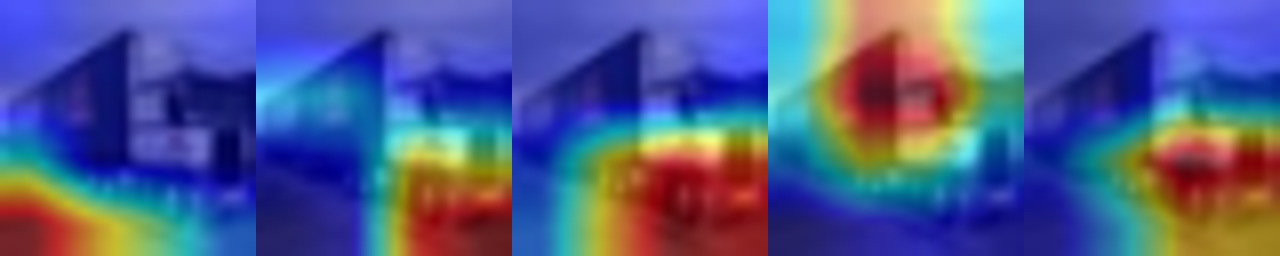

layer: 40 Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


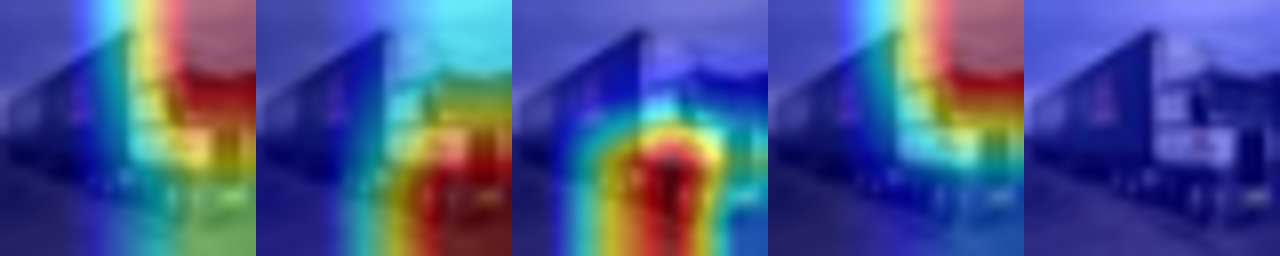

layer: 43 Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


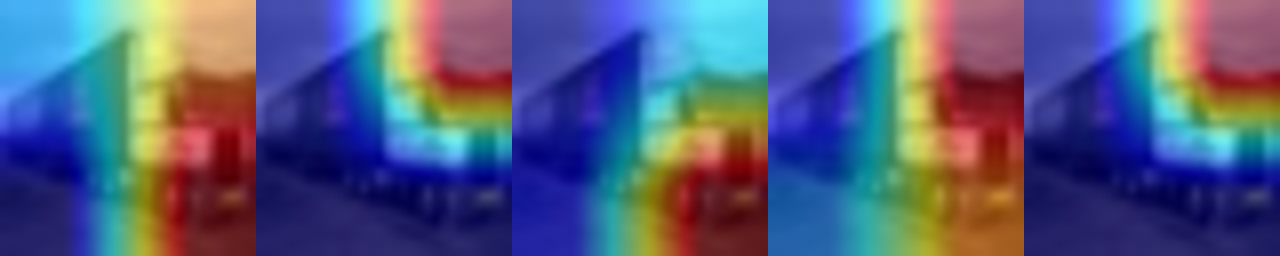

layer: 46 Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


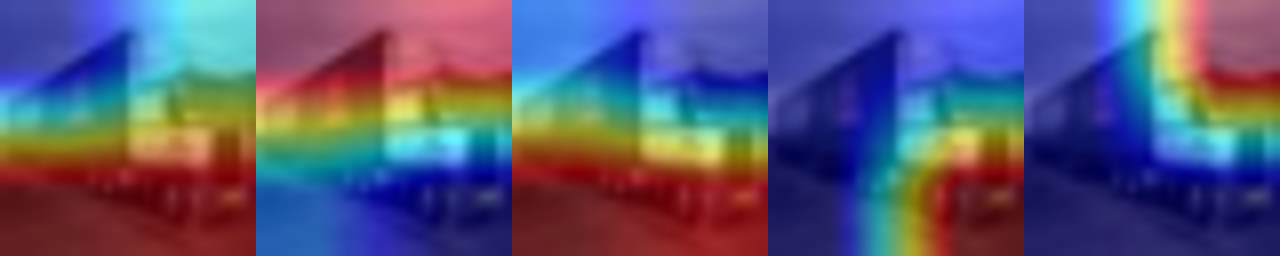

layer: 49 Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


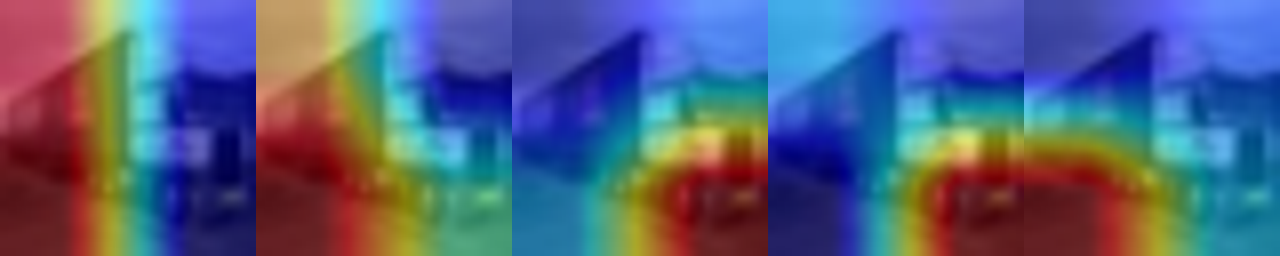

In [15]:
batch = inputs
index = 34
transform = T.ToPILImage()
# print(input[index].min())
rgb_img = np.moveaxis((inputs[index].numpy() + abs(inputs[index].min().item())) / (inputs[index].max().item() + abs(inputs[index].min().item())),0, 2)
rgb_img_pil = Image.fromarray(np.uint8(rgb_img*255))
print("Pretrained Model, Lottery Jackpot Model, GAL Model, GraSP Model, Prune From Scratch Model")

gal_layer = 0
for i in range(len(pretrain_model.feature)):
    gal_layer += 1 if isinstance(GAL_model.feature[i], load_model.Mask) else 0
    if isinstance(pretrain_model.feature[i], torch.nn.Conv2d):
        print('layer:',i, pretrain_model.feature[i])
        pre_img = Image.fromarray(grad_cam_visualization(pretrain_model, inputs[index][None,:,:,:], target_layers=[pretrain_model.feature[i]])).resize((256,256))
        lottery_img = Image.fromarray(grad_cam_visualization(lottery_jackpot_model, inputs[index][None,:,:,:], target_layers=[lottery_jackpot_model.feature[i]])).resize((256,256))
        GAL_img = Image.fromarray(grad_cam_visualization(GAL_model, inputs[index][None,:,:,:], target_layers=[GAL_model.feature[gal_layer]])).resize((256,256))
        GraSP_img = Image.fromarray(grad_cam_visualization(GraSP_model, inputs[index][None,:,:,:], target_layers=[GraSP_model.feature[i]])).resize((256,256))
        prune_scratch_img = Image.fromarray(grad_cam_visualization(prune_scratch_model, inputs[index][None,:,:,:], target_layers=[prune_scratch_model.feature[i]])).resize((256,256))
        display(Image.fromarray(np.hstack((np.array(pre_img),np.array(lottery_img),np.array(GAL_img),np.array(GraSP_img),np.array(prune_scratch_img)))))
    gal_layer += 1